# Death Cox regression

Useful links:
- https://www.nature.com/articles/s41586-020-2521-4.pdf
- https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/articles/coronavirusrelateddeathsbyethnicgroupenglandandwales/2march2020to10april2020

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

In [2]:
from lifelines import CoxPHFitter

In [3]:
record_path = "./records/test_record_1/"

## Import data

In [4]:
people_df = pd.read_csv(record_path + "/people.csv")

In [5]:
people_df.set_index('id', inplace=True)

In [6]:
deaths_df = pd.read_csv(record_path + "/deaths.csv")

In [7]:
deaths_df = deaths_df.rename(columns={"Unnamed: 0": "id"})

In [8]:
deaths_df.set_index('id', inplace=True)

In [9]:
remove_care_home = False

## Process data

In [10]:
study_duration = (datetime(2020, 5, 16, 0, 0) - datetime(2020, 2, 1, 0, 0)).days

In [11]:
people_df = people_df.sort_index()

In [12]:
people_df_died = list(np.zeros(len(people_df)))
people_df_days_dead = list(np.ones(len(people_df)) * study_duration)
for idx, row in tqdm(deaths_df.iterrows(), total = len(deaths_df)):
    days_dead = (datetime.strptime(row["timestamp"], "%Y-%m-%d") - datetime(2020, 2, 1, 0, 0)).days
    if days_dead < study_duration:
        people_df_died[idx] = 1
        people_df_days_dead[idx] = days_dead

100%|██████████| 56587/56587 [00:04<00:00, 11774.58it/s]


In [13]:
people_df["died"] = list(np.array(people_df_died).astype(int))
people_df["days"] = list(np.array(people_df_days_dead).astype(int))

In [14]:
if remove_care_home:
    people_df = people_df[people_df["residence_type"] == "household"]

In [15]:
people_df.loc[people_df["sex"] == "f", "sex"] = 0
people_df.loc[people_df["sex"] == "m", "sex"] = 1

In [16]:
people_df.loc[people_df["ethnicity"] == "A", "ethnicity"] = 0
people_df.loc[people_df["ethnicity"] == "B", "ethnicity"] = 1
people_df.loc[people_df["ethnicity"] == "C", "ethnicity"] = 2
people_df.loc[people_df["ethnicity"] == "D", "ethnicity"] = 3
people_df.loc[people_df["ethnicity"] == "E", "ethnicity"] = 4

In [17]:
people_df.head()

,age,socioeconomic_index,primary_activity_id,residence_id,area_id,sex,ethnicity,primary_activity_type,residence_type,died,days
id,,,,,,,,,,,
0,0,9,0,37,0,0,0,None,household,0,105
1,0,9,0,34,0,0,0,None,household,0,105
2,1,9,241,38,0,0,4,school,household,0,105
3,1,9,241,30,0,1,0,school,household,0,105
4,1,9,241,37,0,0,1,school,household,0,105


In [18]:
age_deaths_opensafely = {
    "18-39": 0.,
    "40-49": 0.,
    "50-59": 0.02,
    "60-69": 0.05,
    "70-79": 0.14,
    "80-100": 0.57,
}

In [19]:
died = np.array(people_df["died"])
age = np.array(people_df["age"])

In [20]:
died_age = died*age

In [21]:
age_bins = [
    [18,39],
    [40,49],
    [50,59],
    [60,69],
    [70,79],
    [80,100],
]

In [22]:
age_nos = []
age_died_nos = []
age_died_per = []
for age_bin in age_bins:
    age_no = np.where(np.logical_and(age>=age_bin[0], age<=age_bin[1]))[0]
    age_nos.append(len(age_no))
    died_age_no = np.where(np.logical_and(died_age>=age_bin[0], died_age<=age_bin[1]))[0]
    age_died_nos.append(len(died_age_no))
    age_died_per.append(len(died_age_no)*100./len(age_no))

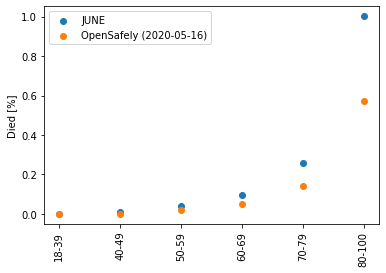

In [23]:
plt.scatter(np.arange(len(age_deaths_opensafely)), age_died_per, label = "JUNE")

plt.scatter(np.arange(len(age_deaths_opensafely)),
            [died for eth, died in age_deaths_opensafely.items()],
            marker = "o",
            label = "OpenSafely (2020-05-16)"
           )

plt.xlabel("")
plt.xticks(ticks = np.arange(len(age_deaths_opensafely)), rotation='vertical', labels=[eth for eth, died in age_deaths_opensafely.items()])
plt.legend()
plt.ylabel("Died [%]")
plt.show()

In [24]:
age_died_nos_opensafely = []
for idx, died in enumerate(age_deaths_opensafely.values()):
    age_died_nos_opensafely.append(age_nos[idx]*died/100.)

In [25]:
age_died_opensafely_norm = np.sum(age_died_nos_opensafely)

In [26]:
age_died_june_norm = np.sum(age_died_nos)

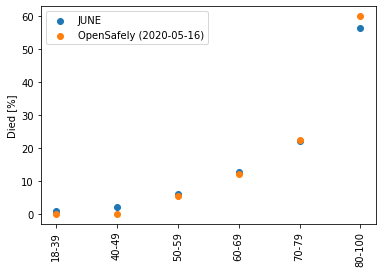

In [27]:
plt.scatter(np.arange(len(age_deaths_opensafely)), np.array(age_died_nos)*100/age_died_june_norm, label = "JUNE")

plt.scatter(np.arange(len(age_deaths_opensafely)),
            np.array(age_died_nos_opensafely)*100/age_died_opensafely_norm,
            marker = "o",
            label = "OpenSafely (2020-05-16)"
           )

plt.xlabel("")
plt.xticks(ticks = np.arange(len(age_deaths_opensafely)), rotation='vertical', labels=[eth for eth, died in age_deaths_opensafely.items()])
plt.legend()
plt.ylabel("Died [%]")
plt.show()

## Ethnicity analysis

### Global analysis

In [28]:
ethnicity_june = ["White", "Mixed", "Asian", "Black", "Other"]

In [29]:
total_ethnicity = np.array(people_df.groupby(["ethnicity"]).size())

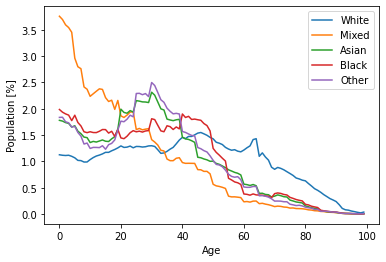

In [30]:
ax0 = (people_df[people_df["ethnicity"] == 0].groupby(["age"]).size()*100/total_ethnicity[0]).plot(
    label = ethnicity_june[0]
)
ax1 = (people_df[people_df["ethnicity"] == 1].groupby(["age"]).size()*100/total_ethnicity[1]).plot(
    label = ethnicity_june[1]
)
ax2 = (people_df[people_df["ethnicity"] == 2].groupby(["age"]).size()*100/total_ethnicity[2]).plot(
    label = ethnicity_june[2]
)
ax3 = (people_df[people_df["ethnicity"] == 3].groupby(["age"]).size()*100/total_ethnicity[3]).plot(
    label = ethnicity_june[3]
)
ax4 = (people_df[people_df["ethnicity"] == 4].groupby(["age"]).size()*100/total_ethnicity[4]).plot(
    label = ethnicity_june[4]
)

plt.legend()
plt.ylabel("Population [%]")
plt.xlabel("Age")
plt.show()

This is broadly in line with the cenus estimates: https://www.ethnicity-facts-figures.service.gov.uk/uk-population-by-ethnicity/demographics/age-groups/latest

In [31]:
ethnicity_deaths_opensafely = {
    "White": 0.07,
    "Mixed": 0.04,
    "South_Asian": 0.06, # note OS put Chinese in Other
    "Black": 0.07,
    "Other": 0.03
}

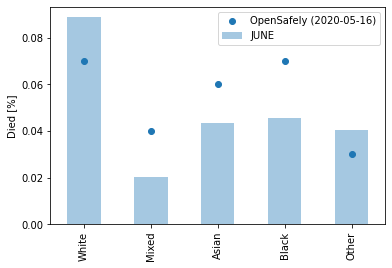

In [32]:
ax = (people_df[people_df["died"] == 1].groupby(["ethnicity"]).size()*100/total_ethnicity).plot.bar(
    rot = 0,
    label = "JUNE",
    alpha = 0.4,
)

plt.scatter(np.arange(len(ethnicity_deaths_opensafely)),
            [died for eth, died in ethnicity_deaths_opensafely.items()],
            marker = "o",
            label = "OpenSafely (2020-05-16)"
           )

plt.xlabel("")
plt.xticks(rotation='vertical')
ax.set_xticklabels(ethnicity_june)
plt.legend()
plt.ylabel("Died [%]")
plt.show()

In [33]:
ethnicity_deaths_nos_opensafely = []
for idx, died in enumerate(ethnicity_deaths_opensafely.values()):
    ethnicity_deaths_nos_opensafely.append(total_ethnicity[idx]*died/100.)

In [34]:
ethnicity_deaths_opensafely_norm = np.sum(ethnicity_deaths_nos_opensafely)

In [35]:
ethnicity_deaths_june_norm = np.sum(people_df[people_df["died"] == 1].groupby(["ethnicity"]).size())

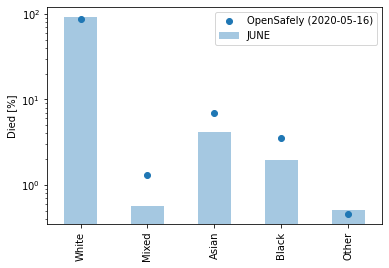

In [36]:
ax = (people_df[people_df["died"] == 1].groupby(["ethnicity"]).size()*100/ethnicity_deaths_june_norm).plot.bar(
    rot = 0,
    label = "JUNE",
    alpha = 0.4,
)

plt.scatter(np.arange(len(ethnicity_deaths_opensafely)),
            np.array(ethnicity_deaths_nos_opensafely)*100/ethnicity_deaths_opensafely_norm,
            marker = "o",
            label = "OpenSafely (2020-05-16)"
           )

plt.xlabel("")
plt.xticks(rotation='vertical')
ax.set_xticklabels(ethnicity_june)
plt.legend()
plt.ylabel("Died [%]")
plt.yscale("log")
plt.show()

### Cox's regression

In [37]:
people_cox_df = people_df[["age", "sex", "ethnicity", "died", "days"]]

In [38]:
people_cox_b = people_cox_df[people_cox_df["ethnicity"].isin([0,1])]
people_cox_c = people_cox_df[people_cox_df["ethnicity"].isin([0,2])]
people_cox_d = people_cox_df[people_cox_df["ethnicity"].isin([0,3])]
people_cox_e = people_cox_df[people_cox_df["ethnicity"].isin([0,4])]

In [39]:
people_cox_c["ethnicity"][people_cox_c["ethnicity"] == 2] = 1
people_cox_d["ethnicity"][people_cox_d["ethnicity"] == 3] = 1
people_cox_e["ethnicity"][people_cox_e["ethnicity"] == 4] = 1

/Users/josephbullock/Documents/covidmodelling/JUNE-private/covidmodelling-private/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/josephbullock/Documents/covidmodelling/JUNE-private/covidmodelling-private/lib/python3.7/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/Users/josephbullock/Documents/covidmodelling/JUNE-private/covidmodelling-private/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is try

In [40]:
cph_b = CoxPHFitter()

In [41]:
cph_b.fit(people_cox_b, duration_col="days", event_col="died", show_progress=True)

Iteration 1: norm_delta = 1.65600, step_size = 0.9000, log_lik = -714411.98578, newton_decrement = 54857.52755, seconds_since_start = 157.4
Iteration 2: norm_delta = 0.76593, step_size = 0.9000, log_lik = -656527.87688, newton_decrement = 6336.18801, seconds_since_start = 306.3
Iteration 3: norm_delta = 0.33823, step_size = 0.9000, log_lik = -649539.85314, newton_decrement = 791.57748, seconds_since_start = 456.3
Iteration 4: norm_delta = 0.04097, step_size = 1.0000, log_lik = -648695.21661, newton_decrement = 9.54906, seconds_since_start = 605.2
Iteration 5: norm_delta = 0.00061, step_size = 1.0000, log_lik = -648685.58408, newton_decrement = 0.00200, seconds_since_start = 753.8
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, log_lik = -648685.58208, newton_decrement = 0.00000, seconds_since_start = 902.0
Convergence success after 6 iterations.


<lifelines.CoxPHFitter: fitted with 4.64639e+07 total observations, 4.64234e+07 right-censored observations>

In [42]:
cph_b.print_summary()

<lifelines.CoxPHFitter: fitted with 4.64639e+07 total observations, 4.64234e+07 right-censored observations>
             duration col = 'days'
                event col = 'died'
      baseline estimation = breslow
   number of observations = 4.64639e+07
number of events observed = 40468
   partial log-likelihood = -648685.58
         time fit was run = 2021-08-09 11:23:01 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.11       1.11       0.00             0.11             0.11                 1.11                 1.12
sex         0.10       1.10       0.01             0.08             0.12                 1.08                 1.12
ethnicity   0.34       1.41       0.06             0.22             0.47                 1.24                 1.60

               z      p   -log2(p)
covariate                         
age       267.30 <0.005        inf
sex         9.37 <0.005      66.86
ethnicity   5.34 <0.005      23.35
---
Concordance = 0.92
Partial AIC = 1297377.16
log-likelihood ratio test = 131452.81 on 3 df
-log2(p) of ll-ratio test = inf

In [43]:
cph_c = CoxPHFitter()

In [44]:
cph_c.fit(people_cox_c, duration_col="days", event_col="died", show_progress=True)

Iteration 1: norm_delta = 1.66768, step_size = 0.9000, log_lik = -744502.43702, newton_decrement = 58039.73988, seconds_since_start = 161.1
Iteration 2: norm_delta = 0.75470, step_size = 0.9000, log_lik = -683564.44959, newton_decrement = 6301.13122, seconds_since_start = 322.2
Iteration 3: norm_delta = 0.31700, step_size = 0.9000, log_lik = -676645.68508, newton_decrement = 730.26220, seconds_since_start = 482.5
Iteration 4: norm_delta = 0.03451, step_size = 1.0000, log_lik = -675870.40671, newton_decrement = 7.26962, seconds_since_start = 642.7
Iteration 5: norm_delta = 0.00035, step_size = 1.0000, log_lik = -675863.08829, newton_decrement = 0.00075, seconds_since_start = 804.0
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, log_lik = -675863.08754, newton_decrement = 0.00000, seconds_since_start = 965.0
Convergence success after 6 iterations.


<lifelines.CoxPHFitter: fitted with 4.94122e+07 total observations, 4.93701e+07 right-censored observations>

In [45]:
cph_c.print_summary()

<lifelines.CoxPHFitter: fitted with 4.94122e+07 total observations, 4.93701e+07 right-censored observations>
             duration col = 'days'
                event col = 'died'
      baseline estimation = breslow
   number of observations = 4.94122e+07
number of events observed = 42026
   partial log-likelihood = -675863.09
         time fit was run = 2021-08-09 11:42:24 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.11       1.11       0.00             0.11             0.11                 1.11                 1.12
sex         0.11       1.11       0.01             0.09             0.13                 1.09                 1.13
ethnicity   0.54       1.71       0.02             0.49             0.58                 1.63                 1.79

               z      p   -log2(p)
covariate                         
age       274.65 <0.005        inf
sex        10.70 <0.005      86.41
ethnicity  22.11 <0.005     357.36
---
Concordance = 0.92
Partial AIC = 1351732.18
log-likelihood ratio test = 137278.70 on 3 df
-log2(p) of ll-ratio test = inf

In [46]:
cph_d = CoxPHFitter()

In [47]:
cph_d.fit(people_cox_d, duration_col="days", event_col="died", show_progress=True)

Iteration 1: norm_delta = 1.64583, step_size = 0.9000, log_lik = -725558.72695, newton_decrement = 55510.42146, seconds_since_start = 153.5
Iteration 2: norm_delta = 0.76798, step_size = 0.9000, log_lik = -666939.62408, newton_decrement = 6430.09826, seconds_since_start = 304.9
Iteration 3: norm_delta = 0.33292, step_size = 0.9000, log_lik = -659860.41562, newton_decrement = 777.40402, seconds_since_start = 455.6
Iteration 4: norm_delta = 0.03817, step_size = 1.0000, log_lik = -659033.03257, newton_decrement = 8.45139, seconds_since_start = 606.2
Iteration 5: norm_delta = 0.00042, step_size = 1.0000, log_lik = -659024.51953, newton_decrement = 0.00103, seconds_since_start = 756.1
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, log_lik = -659024.51850, newton_decrement = 0.00000, seconds_since_start = 906.9
Convergence success after 6 iterations.


<lifelines.CoxPHFitter: fitted with 4.71158e+07 total observations, 4.70747e+07 right-censored observations>

In [48]:
cph_d.print_summary()

<lifelines.CoxPHFitter: fitted with 4.71158e+07 total observations, 4.70747e+07 right-censored observations>
             duration col = 'days'
                event col = 'died'
      baseline estimation = breslow
   number of observations = 4.71158e+07
number of events observed = 41067
   partial log-likelihood = -659024.52
         time fit was run = 2021-08-09 12:02:53 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.11       1.11       0.00             0.11             0.11                 1.11                 1.12
sex         0.10       1.10       0.01             0.08             0.12                 1.08                 1.13
ethnicity   0.50       1.65       0.03             0.43             0.57                 1.54                 1.77

               z      p   -log2(p)
covariate                         
age       269.92 <0.005        inf
sex         9.88 <0.005      74.06
ethnicity  14.41 <0.005     153.91
---
Concordance = 0.92
Partial AIC = 1318055.04
log-likelihood ratio test = 133068.42 on 3 df
-log2(p) of ll-ratio test = inf

In [49]:
cph_e = CoxPHFitter()

In [50]:
cph_e.fit(people_cox_e, duration_col="days", event_col="died", show_progress=True)

Iteration 1: norm_delta = 1.63412, step_size = 0.9000, log_lik = -713439.65377, newton_decrement = 54076.59923, seconds_since_start = 146.0
Iteration 2: norm_delta = 0.77292, step_size = 0.9000, log_lik = -656210.16173, newton_decrement = 6429.26172, seconds_since_start = 293.1
Iteration 3: norm_delta = 0.33920, step_size = 0.9000, log_lik = -649124.12611, newton_decrement = 790.21076, seconds_since_start = 439.4
Iteration 4: norm_delta = 0.03954, step_size = 1.0000, log_lik = -648282.42875, newton_decrement = 8.83390, seconds_since_start = 586.5
Iteration 5: norm_delta = 0.00045, step_size = 1.0000, log_lik = -648273.52870, newton_decrement = 0.00114, seconds_since_start = 732.9
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, log_lik = -648273.52757, newton_decrement = 0.00000, seconds_since_start = 880.0
Convergence success after 6 iterations.


<lifelines.CoxPHFitter: fitted with 4.58181e+07 total observations, 4.57777e+07 right-censored observations>

In [51]:
cph_e.print_summary()

<lifelines.CoxPHFitter: fitted with 4.58181e+07 total observations, 4.57777e+07 right-censored observations>
             duration col = 'days'
                event col = 'died'
      baseline estimation = breslow
   number of observations = 4.58181e+07
number of events observed = 40445
   partial log-likelihood = -648273.53
         time fit was run = 2021-08-09 12:22:13 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.11       1.11       0.00             0.11             0.11                 1.11                 1.12
sex         0.10       1.10       0.01             0.08             0.12                 1.08                 1.12
ethnicity   0.58       1.79       0.07             0.45             0.71                 1.56                 2.04

               z      p   -log2(p)
covariate                         
age       266.99 <0.005        inf
sex         9.38 <0.005      67.08
ethnicity   8.57 <0.005      56.43
---
Concordance = 0.92
Partial AIC = 1296553.06
log-likelihood ratio test = 130332.25 on 3 df
-log2(p) of ll-ratio test = inf

In [2]:
ethnicity_opensafely_age_sex = {
    "White": [1.,1.,1.],
    "Mixed": [1.26,1.62,2.08],
    "South_Asian": [1.54,1.69,1.84], # note the definition is slightly different
    "Black": [1.65,1.88,2.14],
    "Other": [1.13,1.37,1.65],
}

In [3]:
ethnicity_opensafely_fully = {
    "White": [1.,1.,1.],
    "Mixed": [1.11,1.43,1.84],
    "South_Asian": [1.32,1.45,1.58], # note the definition is slightly different
    "Black": [1.29,1.48,1.69],
    "Other": [1.1,1.33,1.61],
}

In [4]:
june_age_sex = {
    "White": [1.,1.,1.],
    "Mixed": [1.24,1.41,1.6],
    "Asian": [1.63,1.71,1.79],
    "Black": [1.54,1.71,1.77],
    "Other": [1.56,1.79,2.04],
}

In [7]:
ethnicity_opensafely_age_sex.values()

dict_values([[1.0, 1.0, 1.0], [1.26, 1.62, 2.08], [1.54, 1.69, 1.84], [1.65, 1.88, 2.14], [1.13, 1.37, 1.65]])

In [11]:
[
    [values[1]-values[0] for values in ethnicity_opensafely_age_sex.values()],
    [values[2]-values[1] for values in ethnicity_opensafely_age_sex.values()]
]

[[0.0,
  0.3600000000000001,
  0.1499999999999999,
  0.22999999999999998,
  0.2400000000000002],
 [0.0,
  0.45999999999999996,
  0.15000000000000013,
  0.26000000000000023,
  0.2799999999999998]]

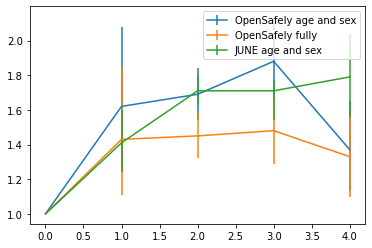

In [14]:
plt.errorbar(
    x = np.arange(len(ethnicity_opensafely_age_sex)),
    y = [values[1] for values in ethnicity_opensafely_age_sex.values()],
    yerr = [
        [values[1]-values[0] for values in ethnicity_opensafely_age_sex.values()],
        [values[2]-values[1] for values in ethnicity_opensafely_age_sex.values()]
        ],
    label = "OpenSafely age and sex"
)

plt.errorbar(
    x = np.arange(len(ethnicity_opensafely_fully)),
    y = [values[1] for values in ethnicity_opensafely_fully.values()],
    yerr = [
        [values[1]-values[0] for values in ethnicity_opensafely_fully.values()],
        [values[2]-values[1] for values in ethnicity_opensafely_fully.values()]
        ],
    label = "OpenSafely fully"
)

plt.errorbar(
    x = np.arange(len(june_age_sex)),
    y = [values[1] for values in june_age_sex.values()],
    yerr = [
        [values[1]-values[0] for values in june_age_sex.values()],
        [values[2]-values[1] for values in june_age_sex.values()]
        ],
    label = "JUNE age and sex"
)

plt.legend()

## Socioeconomic analysis

In [ ]:
deprivation_opensafely = {
    '5': [1.,1.,1.], # least deprived
    '4': [1.05,1.12,1.19],
    '3': [1.15,1.22,1.3],
    '2': [1.42,1.51,1.61],
    '1': [1.68,1.79,1.91] # most deprived
}